In [3]:
# Import necessary libraries

import os
import sys
import copy
import pickle
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras.api._v2.keras as keras
import keras.backend as K
from keras.optimizers.legacy import Adam
from keras.optimizers import SGD
from keras import callbacks
from keras.models import Model
from keras.layers import Masking, Layer, Dense, Input, Activation, Lambda, BatchNormalization, Conv1D, SpatialDropout1D, Add, GlobalAveragePooling1D, LSTM, Dense, concatenate, TimeDistributed, Bidirectional, Dropout, Embedding, Attention, MultiHeadAttention, LayerNormalization, Flatten, Concatenate
from tensorflow.keras.backend import sigmoid
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import tensorflow as tf
from data_utils import *
from model_utils import *
import tensorflow as tf
from collections import Counter

%load_ext autoreload
%autoreload 2

## Load and prepare data

In [4]:
# Load data
train_data, train_label, train_mask, test_data, test_label, test_mask, train_text, train_audio, train_visual, test_text, test_audio, test_visual = load_data()

Max length of sequences:  110

Number of training samples: 120
Number of testing samples: 31

Train text shape: 120 samples, 110 timesteps, 100 features
Train audio shape: 120 samples, 110 timesteps, 100 features
Train visual shape: 120 samples, 110 timesteps, 512 features

Test text shape: 31 samples, 110 timesteps, 100 features
Test audio shape: 31 samples, 110 timesteps, 100 features
Test visual shape: 31 samples, 110 timesteps, 512 features



In [5]:
train_dataset, validation_dataset = create_and_split_multimodal_dataset(audio=train_audio, visual=train_visual, text=train_text, data=train_data, labels=train_label, mask=train_mask, batch_size=32, train_size=0.8, shuffle=True)
test_dataset = tf.data.Dataset.from_tensor_slices(((test_audio, test_visual, test_text, test_data), test_label, test_mask)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

2024-04-15 22:35:52.940072: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-15 22:35:52.940104: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-15 22:35:52.940110: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-15 22:35:52.940153: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-15 22:35:52.940177: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Models and Modalities

In [86]:
class RNNModel(Model):
    def __init__(self, num_classes, modality):
        super(RNNModel, self).__init__()
        self.num_classes = num_classes
        self.modality = modality
        
        self.mask = Masking(mask_value=0.0)
        self.attention = MultiHeadAttention(num_heads=4, key_dim=64, value_dim=64)
        self.bilstm1 = Bidirectional(LSTM(64, return_sequences=True))
        self.bilstm2 = Bidirectional(LSTM(64, return_sequences=True))
        self.dropout = Dropout(0.5)
        self.dense = Dense(64, activation='relu')
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        audio_features, video_features, text_features, all_features = inputs
        if self.modality == 'audio':
            inputs = audio_features
        elif self.modality == 'video':
            inputs = video_features
        elif self.modality == 'text':
            inputs = text_features
        elif self.modality == 'multimodal':
            inputs = all_features
        x = self.mask(inputs)
        x = self.attention(x, x)
        x = self.bilstm1(x)
        x = self.bilstm2(x)
        x = self.dropout(x)
        x = self.dense(x)
        return self.classifier(x)

    def evaluate_model(self, dataset):
        
        for batch in dataset:
            (inputs, labels, mask) = batch
            predictions = self.predict(inputs)
            y_pred = np.argmax(predictions, axis=-1).flatten()
            y_true = np.argmax(labels, axis=-1).flatten()

            # Apply mask to predictions and true values
            valid_indices = np.where(mask.numpy().flatten() == 1)
            y_pred = y_pred[valid_indices]
            y_true = y_true[valid_indices]

            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

            self.test_metrics = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'cm': confusion_matrix(y_true, y_pred)
            }

    def print_metrics(self):
        print("Test Metrics:")
        print(f"Accuracy: {self.test_metrics['accuracy']:.4f}")
        print(f"Precision: {self.test_metrics['precision']:.4f}")
        print(f"Recall: {self.test_metrics['recall']:.4f}")
        print(f"F1 Score: {self.test_metrics['f1_score']:.4f}")

        class_labels = ['hap', 'ang', 'sad', 'neu']
        print("Confusion Matrix:")
        plt.figure(figsize=(8,6))
        sns.heatmap(self.test_metrics['cm'], annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

Epoch 1/10


2024-04-15 23:13:04.593220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:05.703165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:05.949986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:06.484061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:06.658092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:07.275126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:07.430006: I tensorflow/core/grappler/optimizers/cust

3/3 [==============================] - ETA: 0s - loss: 1.4424 - accuracy: 0.3860WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2024-04-15 23:13:11.351048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:11.952384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:12.044922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:12.337837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:12.422978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 12s 2s/step - loss: 1.4424 - accuracy: 0.3860 - val_loss: 0.9541 - val_accuracy: 0.7323
Epoch 2/10
3/3 [==============================] - 1s 522ms/step - loss: 0.9764 - accuracy: 0.6951 - val_loss: 0.8156 - val_accuracy: 0.7069
Epoch 3/10
3/3 [==============================] - 1s 443ms/step - loss: 0.7362 - accuracy: 0.7519 - val_loss: 0.6304 - val_accuracy: 0.7544
Epoch 4/10
3/3 [==============================] - 1s 466ms/step - loss: 0.6289 - accuracy: 0.7743 - val_loss: 0.5585 - val_accuracy: 0.7748
Epoch 5/10
3/3 [==============================] - 1s 410ms/step - loss: 0.5350 - accuracy: 0.8091 - val_loss: 0.4776 - val_accuracy: 0.8288
Epoch 6/10
3/3 [==============================] - 1s 401ms/step - loss: 0.4565 - accuracy: 0.8410 - val_loss: 0.4144 - val_accuracy: 0.8542
Epoch 7/10
3/3 [==============================] - 1s 389ms/step - loss: 0.3712 - accuracy: 0.8708 - val_loss: 0.2958 - val_accuracy: 0.9088
Epoch 8/10
3/3 [=================

2024-04-15 23:13:24.615290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:25.151861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:25.238779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:25.548818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:25.634778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step
Test Metrics:
Accuracy: 0.7110
Precision: 0.7466
Recall: 0.6808
F1 Score: 0.7009
Confusion Matrix:


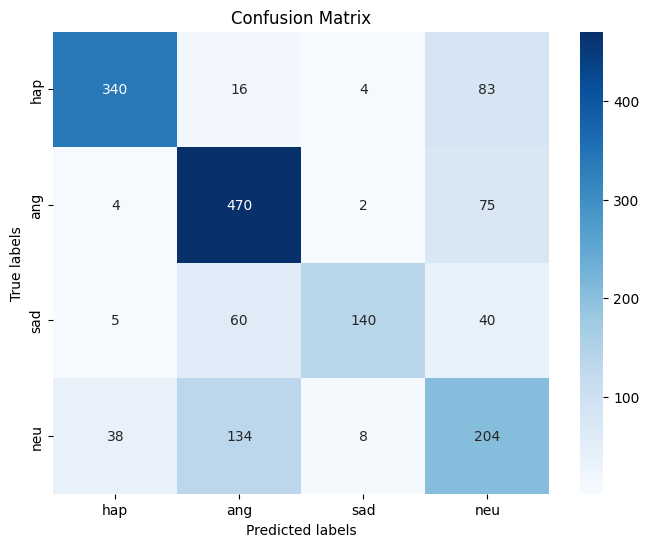

In [87]:
#RNN model for text
rnn_model_text = RNNModel(num_classes=5, modality='text')
rnn_model_text.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn_model_text.fit(train_dataset, epochs=10, validation_data=validation_dataset)
rnn_model_text.evaluate_model(test_dataset)
rnn_model_text.print_metrics()

Epoch 1/10


2024-04-15 23:13:33.626713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:34.729284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:34.903718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:35.275249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:35.449827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:36.050314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:36.202577: I tensorflow/core/grappler/optimizers/cust

3/3 [==============================] - ETA: 0s - loss: 1.5835 - accuracy: 0.3192WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2024-04-15 23:13:39.484267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:40.077572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:40.164258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:40.469045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:40.555942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 11s 2s/step - loss: 1.5835 - accuracy: 0.3192 - val_loss: 1.5140 - val_accuracy: 0.4017
Epoch 2/10
3/3 [==============================] - 2s 565ms/step - loss: 1.4496 - accuracy: 0.4289 - val_loss: 1.2770 - val_accuracy: 0.4157
Epoch 3/10
3/3 [==============================] - 1s 472ms/step - loss: 1.2788 - accuracy: 0.4439 - val_loss: 1.1444 - val_accuracy: 0.4496
Epoch 4/10
3/3 [==============================] - 1s 447ms/step - loss: 1.1541 - accuracy: 0.5228 - val_loss: 1.0730 - val_accuracy: 0.5982
Epoch 5/10
3/3 [==============================] - 1s 438ms/step - loss: 1.0269 - accuracy: 0.5874 - val_loss: 1.0310 - val_accuracy: 0.6000
Epoch 6/10
3/3 [==============================] - 1s 417ms/step - loss: 1.1071 - accuracy: 0.5431 - val_loss: 0.9705 - val_accuracy: 0.5870
Epoch 7/10
3/3 [==============================] - 1s 415ms/step - loss: 1.0220 - accuracy: 0.6063 - val_loss: 0.9658 - val_accuracy: 0.5947
Epoch 8/10
3/3 [=================

2024-04-15 23:13:53.648175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:54.221196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:54.311087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:54.624788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:13:54.711974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step
Test Metrics:
Accuracy: 0.4972
Precision: 0.5054
Recall: 0.4524
F1 Score: 0.4106
Confusion Matrix:


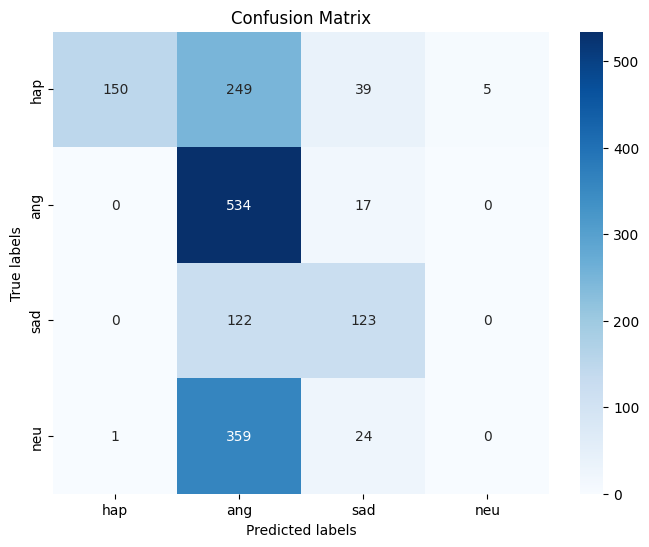

In [88]:
# RNN model for audio
rnn_model_audio = RNNModel(num_classes=5, modality='audio')
rnn_model_audio.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn_model_audio.fit(train_dataset, epochs=10, validation_data=validation_dataset)
rnn_model_audio.evaluate_model(test_dataset)
rnn_model_audio.print_metrics()

Epoch 1/10


2024-04-15 23:13:59.112948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:14:00.240752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:14:00.495441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:14:01.168101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:14:01.345778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:14:01.963902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:14:02.118310: I tensorflow/core/grappler/optimizers/cust

3/3 [==============================] - ETA: 0s - loss: 1.5760 - accuracy: 0.3879WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2024-04-15 23:14:05.971223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:14:06.632691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:14:06.717650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:14:07.057958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:14:07.146108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 12s 2s/step - loss: 1.5760 - accuracy: 0.3879 - val_loss: 1.4969 - val_accuracy: 0.3336
Epoch 2/10
3/3 [==============================] - 2s 587ms/step - loss: 1.4588 - accuracy: 0.3873 - val_loss: 1.2892 - val_accuracy: 0.4649
Epoch 3/10
3/3 [==============================] - 1s 466ms/step - loss: 1.3453 - accuracy: 0.3961 - val_loss: 1.3431 - val_accuracy: 0.4044
Epoch 4/10
3/3 [==============================] - 1s 461ms/step - loss: 1.3386 - accuracy: 0.4248 - val_loss: 1.3675 - val_accuracy: 0.4000
Epoch 5/10
3/3 [==============================] - 1s 458ms/step - loss: 1.3696 - accuracy: 0.3988 - val_loss: 1.3109 - val_accuracy: 0.4391
Epoch 6/10
3/3 [==============================] - 1s 419ms/step - loss: 1.3414 - accuracy: 0.3965 - val_loss: 1.2301 - val_accuracy: 0.5418
Epoch 7/10
3/3 [==============================] - 1s 413ms/step - loss: 1.3127 - accuracy: 0.4117 - val_loss: 1.2583 - val_accuracy: 0.4606
Epoch 8/10
3/3 [=================

2024-04-15 23:14:20.440006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:14:21.394178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:14:21.484359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:14:21.802064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:14:21.896412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step
Test Metrics:
Accuracy: 0.3734
Precision: 0.3688
Recall: 0.2259
F1 Score: 0.1507
Confusion Matrix:


/Users/venessa/Desktop/5342project/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/venessa/Desktop/5342project/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


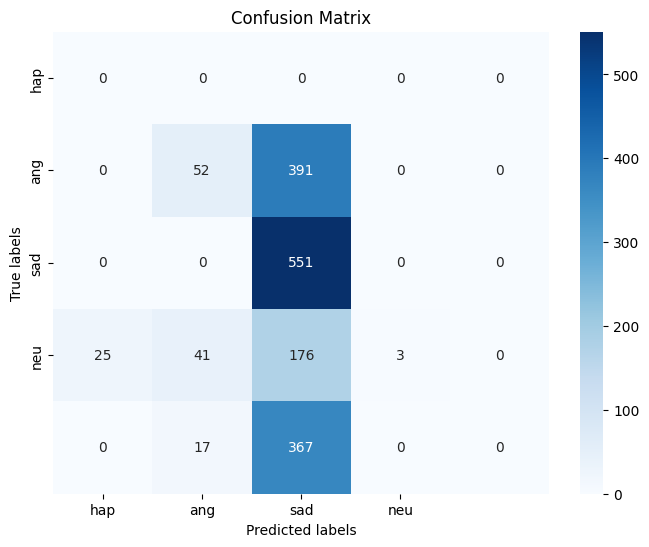

In [89]:
# RNN model for video
rnn_model_video = RNNModel(num_classes=5, modality='video')
rnn_model_video.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn_model_video.fit(train_dataset, epochs=10, validation_data=validation_dataset)
rnn_model_video.evaluate_model(test_dataset)
rnn_model_video.print_metrics()

Epoch 1/10


2024-04-15 22:36:58.303548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:36:59.210974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:36:59.369046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:36:59.578810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:36:59.730124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:37:00.040153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:37:00.190060: I tensorflow/core/grappler/optimizers/cust

3/3 [==============================] - ETA: 0s - loss: 1.4797 - accuracy: 0.4344WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2024-04-15 22:37:02.348971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:37:02.797714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:37:02.857929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:37:02.991949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 9s 1s/step - loss: 1.4797 - accuracy: 0.4344 - val_loss: 1.0564 - val_accuracy: 0.7529
Epoch 2/10


2024-04-15 22:37:03.054564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 268ms/step - loss: 0.9898 - accuracy: 0.7354 - val_loss: 0.7294 - val_accuracy: 0.7597
Epoch 3/10
3/3 [==============================] - 1s 256ms/step - loss: 0.7109 - accuracy: 0.7563 - val_loss: 0.5947 - val_accuracy: 0.7616
Epoch 4/10
3/3 [==============================] - 1s 267ms/step - loss: 0.5747 - accuracy: 0.7907 - val_loss: 0.5480 - val_accuracy: 0.8166
Epoch 5/10
3/3 [==============================] - 1s 257ms/step - loss: 0.5110 - accuracy: 0.8171 - val_loss: 0.4159 - val_accuracy: 0.8571
Epoch 6/10
3/3 [==============================] - 1s 247ms/step - loss: 0.4527 - accuracy: 0.8342 - val_loss: 0.4646 - val_accuracy: 0.8379
Epoch 7/10
3/3 [==============================] - 1s 254ms/step - loss: 0.4023 - accuracy: 0.8561 - val_loss: 0.3862 - val_accuracy: 0.8673
Epoch 8/10
3/3 [==============================] - 1s 245ms/step - loss: 0.3559 - accuracy: 0.8739 - val_loss: 0.2514 - val_accuracy: 0.9143
Epoch 9/10
3/3 [===============

2024-04-15 22:37:10.836330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:37:11.255205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:37:11.318628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:37:11.465198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 22:37:11.529260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step
Test Metrics:
Accuracy: 0.6827
Precision: 0.7463
Recall: 0.6610
F1 Score: 0.6813
Confusion Matrix:


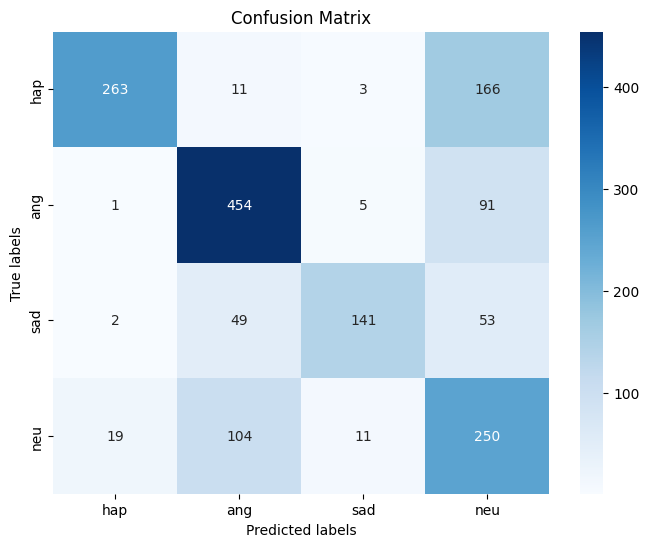

In [9]:
# RNN model for all modalities
rnn_model_all = RNNModel(num_classes=5, modality='multimodal')
rnn_model_all.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn_model_all.fit(train_dataset, epochs=10, validation_data=validation_dataset)
rnn_model_all.evaluate_model(test_dataset)
rnn_model_all.print_metrics()

In [51]:
class CNNModel(Model):
    def __init__(self, num_classes, modality):
        super(CNNModel, self).__init__()
        self.num_classes = num_classes
        self.modality = modality
        self.mask = Masking(mask_value=0.0)
        self.conv1 = Conv1D(64, kernel_size=12, activation='relu', padding='same')
        self.conv2 = Conv1D(64, kernel_size=8, activation='relu', padding='same')
        self.conv3 = Conv1D(64, kernel_size=4, activation='relu', padding='same')
        self.dense1 = Dense(32, activation='relu')
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        audio_features, video_features, text_features, all_features = inputs
        if self.modality == 'audio':
            inputs = audio_features
        elif self.modality == 'video':
            inputs = video_features
        elif self.modality == 'text':
            inputs = text_features
        elif self.modality == 'multimodal':
            inputs = all_features

        x = self.mask(inputs)
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dense1(x)

        return self.classifier(x)

    def evaluate_model(self, dataset):
        
        for batch in dataset:
            (inputs, labels, mask) = batch
            predictions = self.predict(inputs)
            y_pred = np.argmax(predictions, axis=-1).flatten()
            y_true = np.argmax(labels, axis=-1).flatten()

            # Apply mask to predictions and true values
            valid_indices = np.where(mask.numpy().flatten() == 1)
            y_pred = y_pred[valid_indices]
            y_true = y_true[valid_indices]

            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

            self.test_metrics = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'cm': confusion_matrix(y_true, y_pred)
            }

    def print_metrics(self):
        print("Test Metrics:")
        print(f"Accuracy: {self.test_metrics['accuracy']:.4f}")
        print(f"Precision: {self.test_metrics['precision']:.4f}")
        print(f"Recall: {self.test_metrics['recall']:.4f}")
        print(f"F1 Score: {self.test_metrics['f1_score']:.4f}")

        class_labels = ['hap', 'ang', 'sad', 'neu']
        print("Confusion Matrix:")
        plt.figure(figsize=(8,6))
        sns.heatmap(self.test_metrics['cm'], annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

Epoch 1/10


2024-04-15 22:52:56.989771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 142ms/step - loss: 0.8009 - accuracy: 0.3794 - val_loss: 0.2947 - val_accuracy: 0.3163
Epoch 2/10
1/3 [=========>....................] - ETA: 0s - loss: 0.3206 - accuracy: 0.3219

2024-04-15 22:52:57.484596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 53ms/step - loss: 0.3001 - accuracy: 0.3394 - val_loss: 0.2770 - val_accuracy: 0.3314
Epoch 3/10
3/3 [==============================] - 0s 39ms/step - loss: 0.2113 - accuracy: 0.3715 - val_loss: 0.2007 - val_accuracy: 0.4144
Epoch 4/10
3/3 [==============================] - 0s 34ms/step - loss: 0.1633 - accuracy: 0.3754 - val_loss: 0.1545 - val_accuracy: 0.3989
Epoch 5/10
3/3 [==============================] - 0s 32ms/step - loss: 0.1257 - accuracy: 0.3876 - val_loss: 0.1015 - val_accuracy: 0.4114
Epoch 6/10
3/3 [==============================] - 0s 39ms/step - loss: 0.1070 - accuracy: 0.4116 - val_loss: 0.0938 - val_accuracy: 0.3788
Epoch 7/10
3/3 [==============================] - 0s 36ms/step - loss: 0.0921 - accuracy: 0.4100 - val_loss: 0.0899 - val_accuracy: 0.3917
Epoch 8/10
3/3 [==============================] - 0s 34ms/step - loss: 0.0815 - accuracy: 0.4076 - val_loss: 0.0723 - val_accuracy: 0.3928
Epoch 9/10
3/3 [======================

2024-04-15 22:52:58.659585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


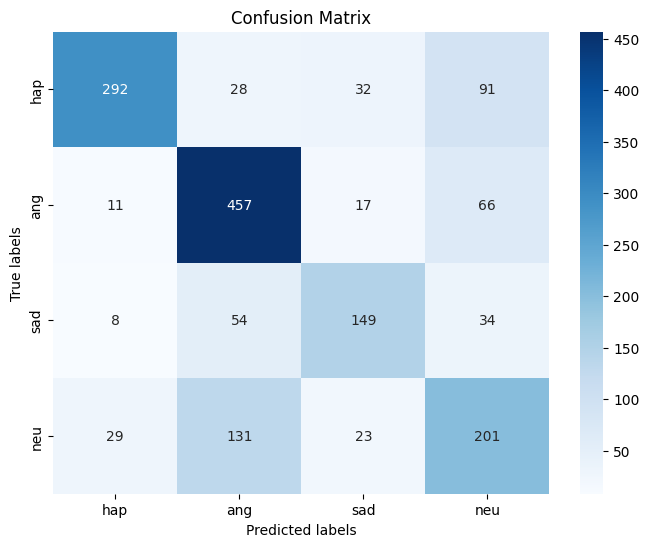

In [52]:
# CNN model for text
cnn_model_text = CNNModel(num_classes=5, modality='text')
cnn_model_text.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model_text.fit(train_dataset, epochs=10, validation_data=validation_dataset)
cnn_model_text.evaluate_model(test_dataset)
cnn_model_text.print_metrics()

Epoch 1/10


2024-04-15 22:53:08.370246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 143ms/step - loss: 0.7118 - accuracy: 0.2978 - val_loss: 0.7213 - val_accuracy: 0.2447
Epoch 2/10
1/3 [=========>....................] - ETA: 0s - loss: 0.7136 - accuracy: 0.2082

2024-04-15 22:53:08.816999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 47ms/step - loss: 0.6711 - accuracy: 0.2071 - val_loss: 0.5282 - val_accuracy: 0.2076
Epoch 3/10
3/3 [==============================] - 0s 51ms/step - loss: 0.5848 - accuracy: 0.2313 - val_loss: 0.5771 - val_accuracy: 0.2375
Epoch 4/10
3/3 [==============================] - 0s 49ms/step - loss: 0.5099 - accuracy: 0.2285 - val_loss: 0.5234 - val_accuracy: 0.2144
Epoch 5/10
3/3 [==============================] - 0s 35ms/step - loss: 0.4684 - accuracy: 0.2299 - val_loss: 0.4839 - val_accuracy: 0.2504
Epoch 6/10
3/3 [==============================] - 0s 33ms/step - loss: 0.4563 - accuracy: 0.2545 - val_loss: 0.3629 - val_accuracy: 0.2371
Epoch 7/10
3/3 [==============================] - 0s 35ms/step - loss: 0.4673 - accuracy: 0.2425 - val_loss: 0.3935 - val_accuracy: 0.2799
Epoch 8/10
3/3 [==============================] - 0s 33ms/step - loss: 0.4312 - accuracy: 0.2695 - val_loss: 0.4280 - val_accuracy: 0.2367
Epoch 9/10
3/3 [======================

2024-04-15 22:53:10.001747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


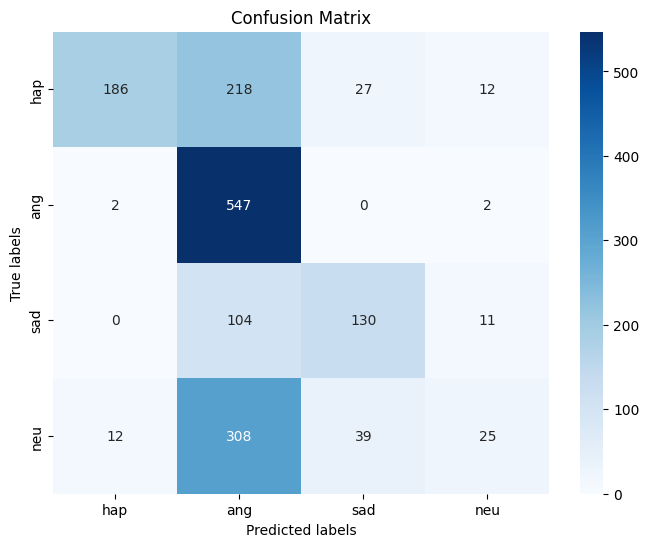

In [54]:
# CNN model for audio
cnn_model_audio = CNNModel(num_classes=5, modality='audio')
cnn_model_audio.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model_audio.fit(train_dataset, epochs=10, validation_data=validation_dataset)
cnn_model_audio.evaluate_model(test_dataset)
cnn_model_audio.print_metrics()

Epoch 1/10


2024-04-15 22:53:13.149359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 140ms/step - loss: 0.7222 - accuracy: 0.2972 - val_loss: 0.7806 - val_accuracy: 0.2019
Epoch 2/10


2024-04-15 22:53:13.613512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 56ms/step - loss: 0.6474 - accuracy: 0.1847 - val_loss: 0.6313 - val_accuracy: 0.2159
Epoch 3/10
3/3 [==============================] - 0s 46ms/step - loss: 0.6256 - accuracy: 0.1885 - val_loss: 0.5527 - val_accuracy: 0.2629
Epoch 4/10
3/3 [==============================] - 0s 43ms/step - loss: 0.6233 - accuracy: 0.1867 - val_loss: 0.5527 - val_accuracy: 0.1758
Epoch 5/10
3/3 [==============================] - 0s 48ms/step - loss: 0.5925 - accuracy: 0.1887 - val_loss: 0.5005 - val_accuracy: 0.1549
Epoch 6/10
3/3 [==============================] - 0s 42ms/step - loss: 0.5596 - accuracy: 0.1759 - val_loss: 0.5615 - val_accuracy: 0.2197
Epoch 7/10
3/3 [==============================] - 0s 50ms/step - loss: 0.5199 - accuracy: 0.2052 - val_loss: 0.4784 - val_accuracy: 0.2261
Epoch 8/10
3/3 [==============================] - 0s 46ms/step - loss: 0.5133 - accuracy: 0.2004 - val_loss: 0.5237 - val_accuracy: 0.2739
Epoch 9/10
3/3 [======================

2024-04-15 22:53:14.973290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


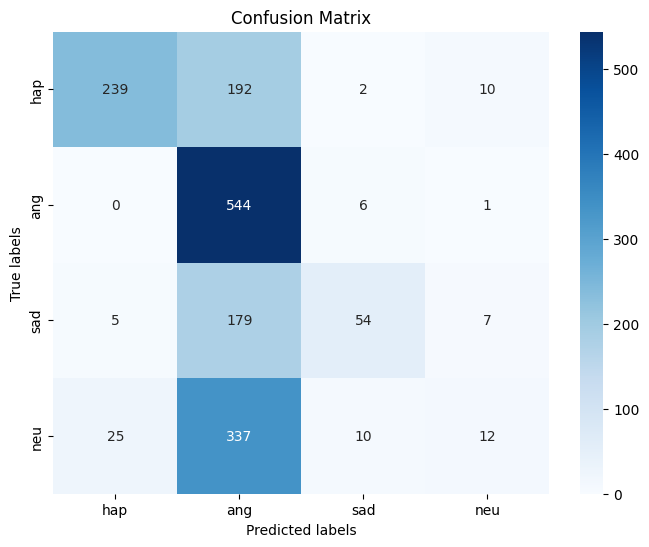

In [ ]:
# CNN model for video
cnn_model_video = CNNModel(num_classes=5, modality='video')
cnn_model_video.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model_video.fit(train_dataset, epochs=10, validation_data=validation_dataset)
cnn_model_video.evaluate_model(test_dataset)
cnn_model_video.print_metrics()

Epoch 1/10


2024-04-15 22:53:24.995068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 159ms/step - loss: 0.6520 - accuracy: 0.3687 - val_loss: 0.2884 - val_accuracy: 0.3417
Epoch 2/10


2024-04-15 22:53:25.643567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 184ms/step - loss: 0.2326 - accuracy: 0.3654 - val_loss: 0.2253 - val_accuracy: 0.3659
Epoch 3/10
3/3 [==============================] - 0s 85ms/step - loss: 0.1845 - accuracy: 0.3803 - val_loss: 0.1481 - val_accuracy: 0.4227
Epoch 4/10
3/3 [==============================] - 0s 49ms/step - loss: 0.1423 - accuracy: 0.3967 - val_loss: 0.1247 - val_accuracy: 0.3758
Epoch 5/10
3/3 [==============================] - 0s 67ms/step - loss: 0.1152 - accuracy: 0.4055 - val_loss: 0.1057 - val_accuracy: 0.4220
Epoch 6/10
3/3 [==============================] - 0s 59ms/step - loss: 0.0957 - accuracy: 0.4102 - val_loss: 0.0927 - val_accuracy: 0.4402
Epoch 7/10
3/3 [==============================] - 0s 64ms/step - loss: 0.0799 - accuracy: 0.4119 - val_loss: 0.0701 - val_accuracy: 0.4167
Epoch 8/10
3/3 [==============================] - 0s 71ms/step - loss: 0.0678 - accuracy: 0.4184 - val_loss: 0.0631 - val_accuracy: 0.4473
Epoch 9/10
3/3 [=====================

2024-04-15 22:53:27.739674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test Metrics:
Accuracy: 0.6833
Precision: 0.6992
Recall: 0.6594
F1 Score: 0.6712
Confusion Matrix:


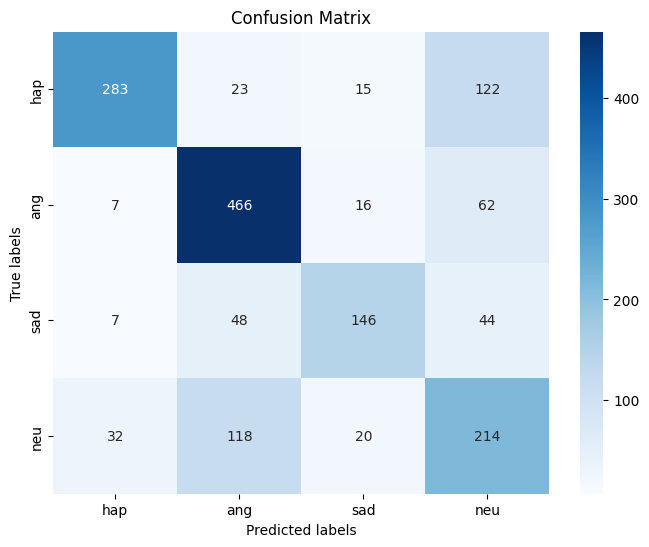

In [56]:
# CNN model for all modalities
cnn_model_multimodal = CNNModel(num_classes=5, modality='multimodal')
cnn_model_multimodal.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model_multimodal.fit(train_dataset, epochs=10, validation_data=validation_dataset)
cnn_model_multimodal.evaluate_model(test_dataset)
cnn_model_multimodal.print_metrics()

In [81]:
class TransformerModel(Model):
    def __init__(self, num_classes, modality, num_heads=4):
        super(TransformerModel, self).__init__()
        self.num_classes = num_classes
        self.modality = modality
        if self.modality == 'audio':
            self.d_model = 100
        elif self.modality == 'video':
            self.d_model = 512
        elif self.modality == 'text':
            self.d_model = 100
        elif self.modality == 'multimodal':
            self.d_model = 712
        self.num_heads = num_heads
        self.dff = 2048
        self.rate = 0.1
        self.mask = Masking(mask_value=0.0)
        self.transformer_block1 = TransformerBlock(d_model=self.d_model, num_heads=self.num_heads, dff=self.dff, rate=self.rate)
        self.transformer_block2 = TransformerBlock(d_model=self.d_model, num_heads=self.num_heads, dff=self.dff, rate=self.rate)
        self.dense = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        audio_features, video_features, text_features, all_features = inputs
        if self.modality == 'audio':
            inputs = audio_features
        elif self.modality == 'video':
            inputs = video_features
        elif self.modality == 'text':
            inputs = text_features
        elif self.modality == 'multimodal':
            inputs = all_features
        
        x = self.mask(inputs)
        x = self.transformer_block1(x)
        x = self.transformer_block2(x)
        x = self.dense(x)

        return x
    

    def evaluate_model(self, dataset):
        
        for batch in dataset:
            (inputs, labels, mask) = batch
            predictions = self.predict(inputs)
            y_pred = np.argmax(predictions, axis=-1).flatten()
            y_true = np.argmax(labels, axis=-1).flatten()

            # Apply mask to predictions and true values
            valid_indices = np.where(mask.numpy().flatten() == 1)
            y_pred = y_pred[valid_indices]
            y_true = y_true[valid_indices]

            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

            self.test_metrics = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'cm': confusion_matrix(y_true, y_pred)
            }

    def print_metrics(self):
        print("Test Metrics:")
        print(f"Accuracy: {self.test_metrics['accuracy']:.4f}")
        print(f"Precision: {self.test_metrics['precision']:.4f}")
        print(f"Recall: {self.test_metrics['recall']:.4f}")
        print(f"F1 Score: {self.test_metrics['f1_score']:.4f}")

        class_labels = ['hap', 'ang', 'sad', 'neu']
        print("Confusion Matrix:")
        plt.figure(figsize=(8,6))
        sns.heatmap(self.test_metrics['cm'], annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()


Epoch 1/10


2024-04-15 23:10:43.964759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 0.4651 - accuracy: 0.3245WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2024-04-15 23:10:46.858227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 4s 819ms/step - loss: 0.4651 - accuracy: 0.3245 - val_loss: 0.1084 - val_accuracy: 0.4189
Epoch 2/10
3/3 [==============================] - 1s 258ms/step - loss: 0.1111 - accuracy: 0.4038 - val_loss: 0.1308 - val_accuracy: 0.4621
Epoch 3/10
3/3 [==============================] - 1s 243ms/step - loss: 0.1063 - accuracy: 0.4121 - val_loss: 0.1034 - val_accuracy: 0.4148
Epoch 4/10
3/3 [==============================] - 1s 243ms/step - loss: 0.0970 - accuracy: 0.4131 - val_loss: 0.0995 - val_accuracy: 0.4170
Epoch 5/10
3/3 [==============================] - 1s 210ms/step - loss: 0.0844 - accuracy: 0.4073 - val_loss: 0.0739 - val_accuracy: 0.3992
Epoch 6/10
3/3 [==============================] - 0s 164ms/step - loss: 0.0778 - accuracy: 0.4184 - val_loss: 0.0724 - val_accuracy: 0.4402
Epoch 7/10
3/3 [==============================] - 0s 180ms/step - loss: 0.0722 - accuracy: 0.4125 - val_loss: 0.0609 - val_accuracy: 0.4330
Epoch 8/10
3/3 [===============

2024-04-15 23:10:52.847162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 707ms/step
Test Metrics:
Accuracy: 0.6833
Precision: 0.6962
Recall: 0.6653
F1 Score: 0.6751
Confusion Matrix:


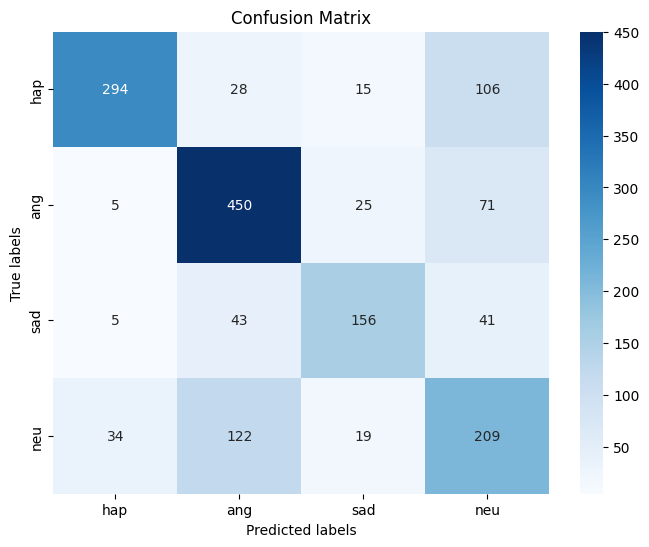

In [83]:
# Transformer for text
transformer_model_text = TransformerModel(num_classes=5, modality='text')
transformer_model_text.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model_text.fit(train_dataset, epochs=10, validation_data=validation_dataset)
transformer_model_text.evaluate_model(test_dataset)
transformer_model_text.print_metrics()

Epoch 1/10


2024-04-15 23:10:57.995907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 1.2002 - accuracy: 0.2462WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2024-04-15 23:11:00.747859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 4s 733ms/step - loss: 1.2002 - accuracy: 0.2462 - val_loss: 1.1203 - val_accuracy: 0.1913
Epoch 2/10
3/3 [==============================] - 1s 326ms/step - loss: 0.8969 - accuracy: 0.2209 - val_loss: 0.6758 - val_accuracy: 0.2083
Epoch 3/10
3/3 [==============================] - 1s 228ms/step - loss: 0.6186 - accuracy: 0.1915 - val_loss: 0.5682 - val_accuracy: 0.2273
Epoch 4/10
3/3 [==============================] - 1s 228ms/step - loss: 0.5431 - accuracy: 0.2074 - val_loss: 0.4397 - val_accuracy: 0.1761
Epoch 5/10
3/3 [==============================] - 1s 183ms/step - loss: 0.4850 - accuracy: 0.2217 - val_loss: 0.4487 - val_accuracy: 0.2216
Epoch 6/10
3/3 [==============================] - 1s 192ms/step - loss: 0.4604 - accuracy: 0.2388 - val_loss: 0.4901 - val_accuracy: 0.2352
Epoch 7/10
3/3 [==============================] - 0s 166ms/step - loss: 0.4625 - accuracy: 0.2527 - val_loss: 0.3983 - val_accuracy: 0.2235
Epoch 8/10
3/3 [===============

2024-04-15 23:11:06.745151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 724ms/step
Test Metrics:
Accuracy: 0.5299
Precision: 0.5461
Recall: 0.5143
F1 Score: 0.5019
Confusion Matrix:


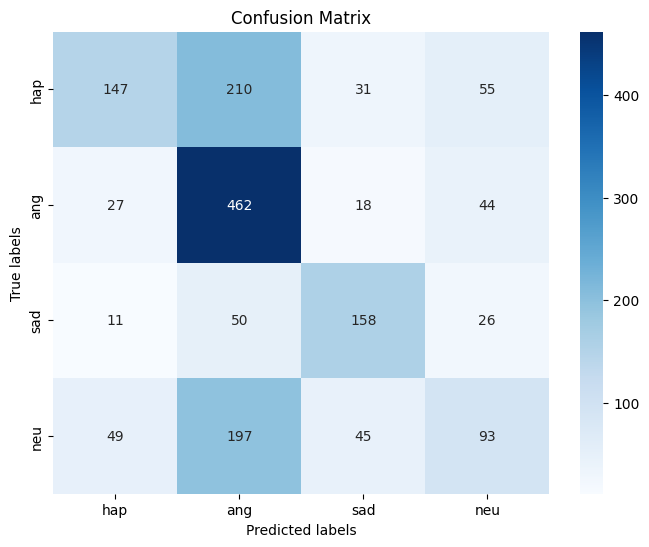

In [ ]:
# Transformer for audio
transformer_model_audio = TransformerModel(num_classes=5, modality='audio')
transformer_model_audio.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model_audio.fit(train_dataset, epochs=10, validation_data=validation_dataset)
transformer_model_audio.evaluate_model(test_dataset)
transformer_model_audio.print_metrics()

Epoch 1/10


2024-04-15 23:02:25.310865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 3.9528 - accuracy: 0.1313WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2024-04-15 23:02:28.321738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 4s 776ms/step - loss: 3.9528 - accuracy: 0.1313 - val_loss: 4.6425 - val_accuracy: 0.1686
Epoch 2/10
3/3 [==============================] - 1s 513ms/step - loss: 3.0899 - accuracy: 0.1322 - val_loss: 1.6827 - val_accuracy: 0.1242
Epoch 3/10
3/3 [==============================] - 1s 425ms/step - loss: 1.2713 - accuracy: 0.0920 - val_loss: 0.7484 - val_accuracy: 0.1723
Epoch 4/10
3/3 [==============================] - 1s 452ms/step - loss: 0.7341 - accuracy: 0.1868 - val_loss: 0.8184 - val_accuracy: 0.2106
Epoch 5/10
3/3 [==============================] - 1s 538ms/step - loss: 0.7088 - accuracy: 0.1254 - val_loss: 0.6020 - val_accuracy: 0.0780
Epoch 6/10
3/3 [==============================] - 1s 433ms/step - loss: 0.6434 - accuracy: 0.1670 - val_loss: 0.7054 - val_accuracy: 0.1939
Epoch 7/10
3/3 [==============================] - 1s 405ms/step - loss: 0.6734 - accuracy: 0.1491 - val_loss: 0.6230 - val_accuracy: 0.2193
Epoch 8/10
3/3 [===============

2024-04-15 23:02:40.323716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 702ms/step
Test Metrics:
Accuracy: 0.3395
Precision: 0.0849
Recall: 0.2500
F1 Score: 0.1267
Confusion Matrix:


/Users/venessa/Desktop/5342project/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


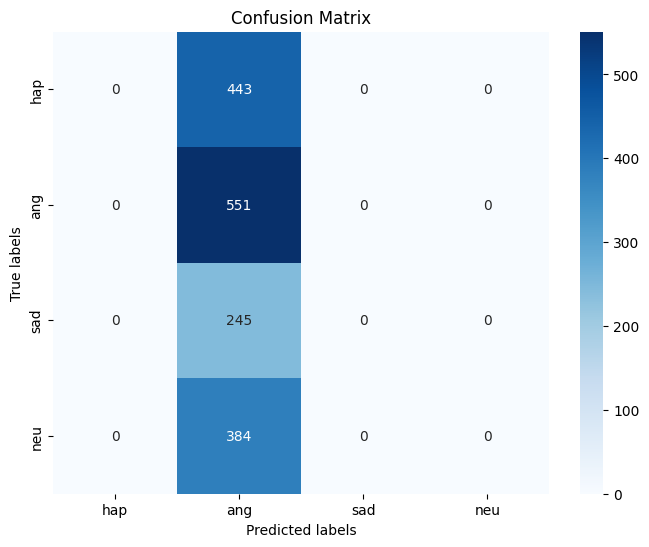

In [66]:
# Transformer for video
transformer_model_video = TransformerModel(num_classes=5, modality='video')
transformer_model_video.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model_video.fit(train_dataset, epochs=10, validation_data=validation_dataset)
transformer_model_video.evaluate_model(test_dataset)
transformer_model_video.print_metrics()

Epoch 1/10


2024-04-15 23:11:29.578353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 0.7533 - accuracy: 0.3012WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2024-04-15 23:11:33.571879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 7s 1s/step - loss: 0.7533 - accuracy: 0.3012 - val_loss: 0.3681 - val_accuracy: 0.4178
Epoch 2/10
3/3 [==============================] - 2s 691ms/step - loss: 0.2413 - accuracy: 0.4049 - val_loss: 0.2716 - val_accuracy: 0.3871
Epoch 3/10
3/3 [==============================] - 2s 612ms/step - loss: 0.1859 - accuracy: 0.3963 - val_loss: 0.1099 - val_accuracy: 0.3985
Epoch 4/10
3/3 [==============================] - 2s 614ms/step - loss: 0.1203 - accuracy: 0.4088 - val_loss: 0.1165 - val_accuracy: 0.3996
Epoch 5/10
3/3 [==============================] - 2s 593ms/step - loss: 0.1120 - accuracy: 0.4048 - val_loss: 0.1035 - val_accuracy: 0.3720
Epoch 6/10
3/3 [==============================] - 2s 622ms/step - loss: 0.0970 - accuracy: 0.4058 - val_loss: 0.0781 - val_accuracy: 0.4458
Epoch 7/10
3/3 [==============================] - 2s 567ms/step - loss: 0.0845 - accuracy: 0.4113 - val_loss: 0.0459 - val_accuracy: 0.3648
Epoch 8/10
3/3 [==================

2024-04-15 23:11:49.832065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 862ms/step
Test Metrics:
Accuracy: 0.6587
Precision: 0.6683
Recall: 0.6336
F1 Score: 0.6405
Confusion Matrix:


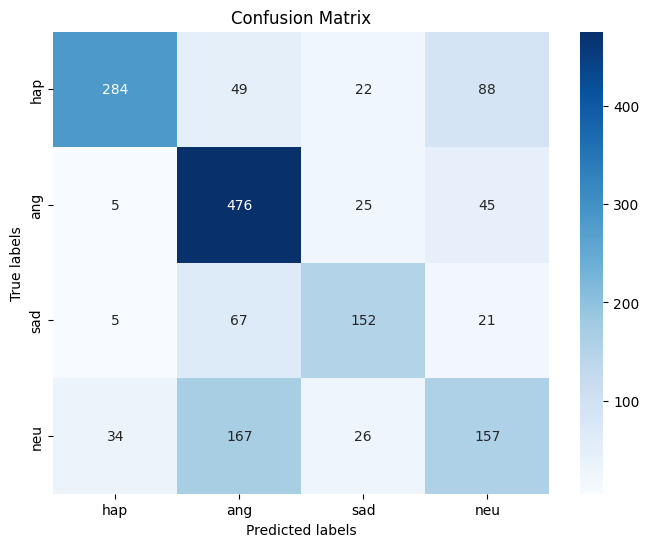

In [85]:
# Transformer for all modalities
transformer_model_multimodal = TransformerModel(num_classes=5, modality='multimodal')
transformer_model_multimodal.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model_multimodal.fit(train_dataset, epochs=10, validation_data=validation_dataset)
transformer_model_multimodal.evaluate_model(test_dataset)
transformer_model_multimodal.print_metrics()

## Early and Late Fusion

In [96]:
class EarlyFusionModel(Model):
    def __init__(self, num_classes, modality='multimodal'):
        super(EarlyFusionModel, self).__init__()
        self.num_classes = num_classes
        self.modality = modality
        self.mask = Masking(mask_value=0.0)
        self.bilstm = Bidirectional(LSTM(64, return_sequences=True))
        self.dense = Dense(64, activation='relu')
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        audio_features, video_features, text_features, all_features = inputs
        if self.modality == 'audio':
            x = audio_features
        elif self.modality == 'video':
            x = video_features
        elif self.modality == 'text':
            x = text_features
        elif self.modality == 'multimodal':
            x = all_features
        x = self.mask(x)
        x = self.bilstm(x)
        x = self.dense(x)
        return self.classifier(x)
    
    def evaluate_model(self, dataset):
        
        for batch in dataset:
            (inputs, labels, mask) = batch
            predictions = self.predict(inputs)
            y_pred = np.argmax(predictions, axis=-1).flatten()
            y_true = np.argmax(labels, axis=-1).flatten()

            # Apply mask to predictions and true values
            valid_indices = np.where(mask.numpy().flatten() == 1)
            y_pred = y_pred[valid_indices]
            y_true = y_true[valid_indices]

            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

            self.test_metrics = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'cm': confusion_matrix(y_true, y_pred)
            }

    def print_metrics(self):
        print("Test Metrics:")
        print(f"Accuracy: {self.test_metrics['accuracy']:.4f}")
        print(f"Precision: {self.test_metrics['precision']:.4f}")
        print(f"Recall: {self.test_metrics['recall']:.4f}")
        print(f"F1 Score: {self.test_metrics['f1_score']:.4f}")

        class_labels = ['hap', 'ang', 'sad', 'neu']
        print("Confusion Matrix:")
        plt.figure(figsize=(8,6))
        sns.heatmap(self.test_metrics['cm'], annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()


Epoch 1/10


2024-04-15 23:40:50.898449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:40:51.661705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:40:51.847335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:40:52.470491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:40:52.623997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 1.3511 - accuracy: 0.4883WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2024-04-15 23:40:54.852229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:40:55.229501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:40:55.317639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 9s 1s/step - loss: 1.3511 - accuracy: 0.4883 - val_loss: 0.8503 - val_accuracy: 0.8764
Epoch 2/10
3/3 [==============================] - 1s 242ms/step - loss: 0.7047 - accuracy: 0.9006 - val_loss: 0.4254 - val_accuracy: 0.9264
Epoch 3/10
3/3 [==============================] - 1s 251ms/step - loss: 0.3841 - accuracy: 0.9323 - val_loss: 0.3430 - val_accuracy: 0.9159
Epoch 4/10
3/3 [==============================] - 1s 184ms/step - loss: 0.2571 - accuracy: 0.9356 - val_loss: 0.2370 - val_accuracy: 0.9298
Epoch 5/10
3/3 [==============================] - 1s 194ms/step - loss: 0.2087 - accuracy: 0.9382 - val_loss: 0.1996 - val_accuracy: 0.9436
Epoch 6/10
3/3 [==============================] - 1s 187ms/step - loss: 0.1746 - accuracy: 0.9432 - val_loss: 0.2148 - val_accuracy: 0.9359
Epoch 7/10
3/3 [==============================] - 0s 168ms/step - loss: 0.1655 - accuracy: 0.9470 - val_loss: 0.1613 - val_accuracy: 0.9537
Epoch 8/10
3/3 [==================

2024-04-15 23:41:01.324080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:01.584397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:01.670070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
Test Metrics:
Accuracy: 0.6981
Precision: 0.7036
Recall: 0.6828
F1 Score: 0.6888
Confusion Matrix:


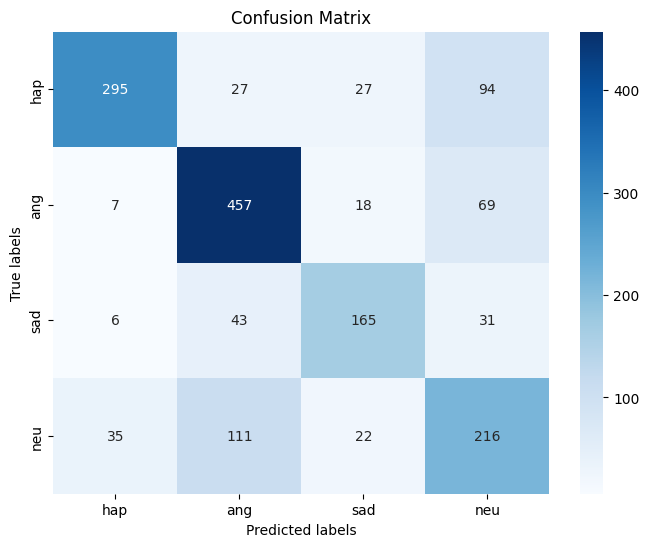

In [97]:
# Early Fusion model for all modalities
early_fusion_model = EarlyFusionModel(num_classes=5, modality='multimodal')
early_fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_fusion_model.fit(train_dataset, epochs=10, validation_data=validation_dataset)
early_fusion_model.evaluate_model(test_dataset)
early_fusion_model.print_metrics()

Epoch 1/10


2024-04-15 23:41:06.171306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:06.859904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:07.074610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:07.801889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:07.947506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 1.4493 - accuracy: 0.3655WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2024-04-15 23:41:09.575246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:09.878517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:09.991440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 7s 1s/step - loss: 1.4493 - accuracy: 0.3655 - val_loss: 1.1033 - val_accuracy: 0.6852
Epoch 2/10
3/3 [==============================] - 1s 274ms/step - loss: 0.9511 - accuracy: 0.7996 - val_loss: 0.7368 - val_accuracy: 0.8769
Epoch 3/10
3/3 [==============================] - 1s 233ms/step - loss: 0.6263 - accuracy: 0.8977 - val_loss: 0.5100 - val_accuracy: 0.9120
Epoch 4/10
3/3 [==============================] - 1s 225ms/step - loss: 0.4142 - accuracy: 0.9275 - val_loss: 0.3479 - val_accuracy: 0.9320
Epoch 5/10
3/3 [==============================] - 1s 183ms/step - loss: 0.2906 - accuracy: 0.9366 - val_loss: 0.2414 - val_accuracy: 0.9444
Epoch 6/10
3/3 [==============================] - 1s 193ms/step - loss: 0.2344 - accuracy: 0.9430 - val_loss: 0.2482 - val_accuracy: 0.9270
Epoch 7/10
3/3 [==============================] - 0s 176ms/step - loss: 0.2017 - accuracy: 0.9440 - val_loss: 0.1795 - val_accuracy: 0.9513
Epoch 8/10
3/3 [==================

2024-04-15 23:41:16.442906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:16.711659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:16.794154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
Test Metrics:
Accuracy: 0.6796
Precision: 0.6856
Recall: 0.6546
F1 Score: 0.6648
Confusion Matrix:


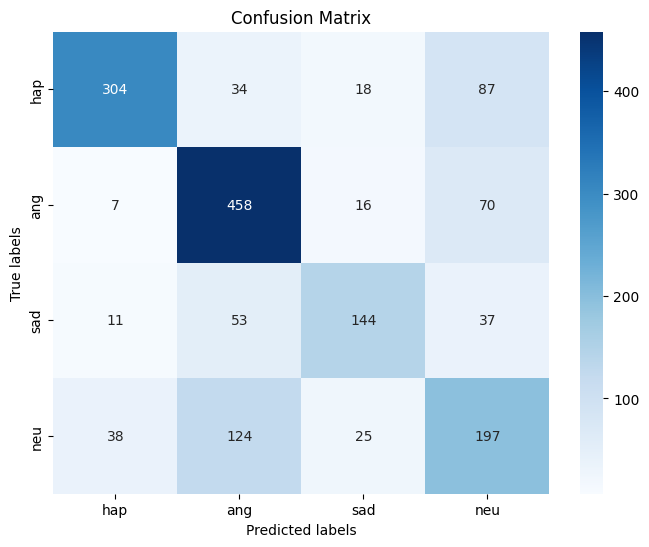

In [98]:
# Early fusion model for text
early_fusion_model_text = EarlyFusionModel(num_classes=5, modality='text')
early_fusion_model_text.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_fusion_model_text.fit(train_dataset, epochs=10, validation_data=validation_dataset)
early_fusion_model_text.evaluate_model(test_dataset)
early_fusion_model_text.print_metrics()

Epoch 1/10


2024-04-15 23:41:41.571693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:42.267177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:42.439726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:43.061748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:43.206457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 1.4583 - accuracy: 0.5204WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2024-04-15 23:41:44.796466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:45.098005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:45.182531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 6s 966ms/step - loss: 1.4583 - accuracy: 0.5204 - val_loss: 1.3589 - val_accuracy: 0.5106
Epoch 2/10
3/3 [==============================] - 1s 318ms/step - loss: 1.3260 - accuracy: 0.5209 - val_loss: 1.2580 - val_accuracy: 0.5115
Epoch 3/10
3/3 [==============================] - 1s 250ms/step - loss: 1.2289 - accuracy: 0.5194 - val_loss: 1.1663 - val_accuracy: 0.5345
Epoch 4/10
3/3 [==============================] - 1s 239ms/step - loss: 1.1863 - accuracy: 0.4964 - val_loss: 1.1084 - val_accuracy: 0.5379
Epoch 5/10
3/3 [==============================] - 1s 198ms/step - loss: 1.0586 - accuracy: 0.5611 - val_loss: 1.0656 - val_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 1s 191ms/step - loss: 1.0652 - accuracy: 0.5052 - val_loss: 1.0158 - val_accuracy: 0.5511
Epoch 7/10
3/3 [==============================] - 1s 231ms/step - loss: 0.9981 - accuracy: 0.5605 - val_loss: 0.9343 - val_accuracy: 0.6403
Epoch 8/10
3/3 [===============

2024-04-15 23:41:51.755465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:52.022566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:41:52.105677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
Test Metrics:
Accuracy: 0.5847
Precision: 0.6146
Recall: 0.5538
F1 Score: 0.5440
Confusion Matrix:


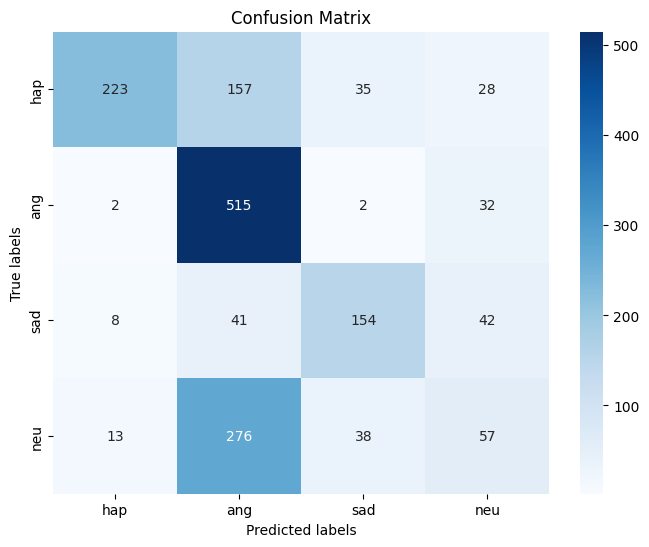

In [99]:
# Early fusion model for audio
early_fusion_model_audio = EarlyFusionModel(num_classes=5, modality='audio')
early_fusion_model_audio.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_fusion_model_audio.fit(train_dataset, epochs=10, validation_data=validation_dataset)
early_fusion_model_audio.evaluate_model(test_dataset)
early_fusion_model_audio.print_metrics()

Epoch 1/10


2024-04-15 23:42:07.223699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:42:07.885400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:42:08.063957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:42:08.857120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:42:09.006173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 1.5927 - accuracy: 0.2093WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2024-04-15 23:42:10.752158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:42:11.049194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:42:11.161007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 7s 1s/step - loss: 1.5927 - accuracy: 0.2093 - val_loss: 1.5653 - val_accuracy: 0.2509
Epoch 2/10
3/3 [==============================] - 1s 274ms/step - loss: 1.5370 - accuracy: 0.3405 - val_loss: 1.4689 - val_accuracy: 0.4930
Epoch 3/10
3/3 [==============================] - 1s 201ms/step - loss: 1.4849 - accuracy: 0.3912 - val_loss: 1.4635 - val_accuracy: 0.3029
Epoch 4/10
3/3 [==============================] - 1s 190ms/step - loss: 1.3800 - accuracy: 0.4380 - val_loss: 1.2964 - val_accuracy: 0.4906
Epoch 5/10
3/3 [==============================] - 1s 239ms/step - loss: 1.3540 - accuracy: 0.4059 - val_loss: 1.4510 - val_accuracy: 0.3112
Epoch 6/10
3/3 [==============================] - 1s 207ms/step - loss: 1.2842 - accuracy: 0.4414 - val_loss: 1.2558 - val_accuracy: 0.4459
Epoch 7/10
3/3 [==============================] - 1s 188ms/step - loss: 1.2839 - accuracy: 0.4184 - val_loss: 1.2111 - val_accuracy: 0.4905
Epoch 8/10
3/3 [==================

2024-04-15 23:42:17.744811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:42:18.079768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:42:18.172441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step
Test Metrics:
Accuracy: 0.4110
Precision: 0.6633
Recall: 0.3251
F1 Score: 0.2752
Confusion Matrix:


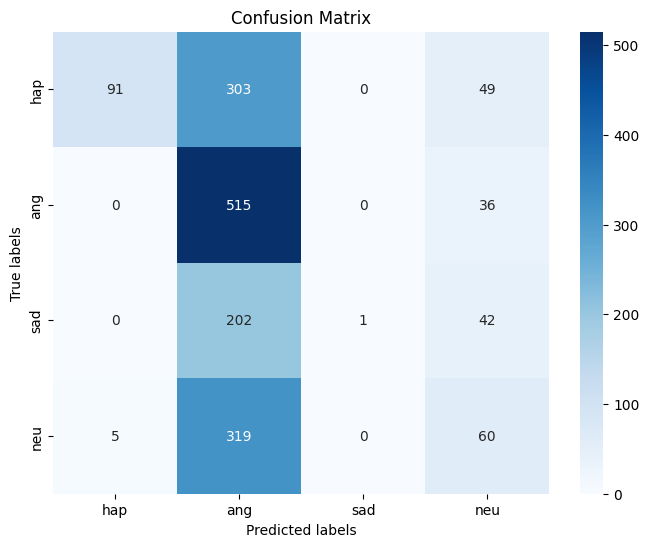

In [100]:
# Early fusion model for video
early_fusion_model_video = EarlyFusionModel(num_classes=5, modality='video')
early_fusion_model_video.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_fusion_model_video.fit(train_dataset, epochs=10, validation_data=validation_dataset)
early_fusion_model_video.evaluate_model(test_dataset)
early_fusion_model_video.print_metrics()

In [94]:
class LateFusionModel(Model):
    def __init__(self, num_classes):
        super(LateFusionModel, self).__init__()
        self.num_classes = num_classes
        self.mask = Masking(mask_value=0.0)
        self.bilstm_audio = Bidirectional(LSTM(64, return_sequences=True))
        self.bilstm_video = Bidirectional(LSTM(64, return_sequences=True))
        self.bilstm_text = Bidirectional(LSTM(64, return_sequences=True))
        self.concat = Concatenate()
        self.dense = Dense(64, activation='relu')
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        audio_features, video_features, text_features, all_features = inputs
        
        audio = self.mask(audio_features)
        video = self.mask(video_features)
        text = self.mask(text_features)
        
        audio = self.bilstm_audio(audio)
        video = self.bilstm_video(video)
        text = self.bilstm_text(text)

        x = self.concat([audio, video, text])
        x = self.dense(x)
        return self.classifier(x)
    
    def evaluate_model(self, dataset):
        
        for batch in dataset:
            (inputs, labels, mask) = batch
            predictions = self.predict(inputs)
            y_pred = np.argmax(predictions, axis=-1).flatten()
            y_true = np.argmax(labels, axis=-1).flatten()

            # Apply mask to predictions and true values
            valid_indices = np.where(mask.numpy().flatten() == 1)
            y_pred = y_pred[valid_indices]
            y_true = y_true[valid_indices]

            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

            self.test_metrics = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'cm': confusion_matrix(y_true, y_pred)
            }

    def print_metrics(self):
        print("Test Metrics:")
        print(f"Accuracy: {self.test_metrics['accuracy']:.4f}")
        print(f"Precision: {self.test_metrics['precision']:.4f}")
        print(f"Recall: {self.test_metrics['recall']:.4f}")
        print(f"F1 Score: {self.test_metrics['f1_score']:.4f}")

        class_labels = ['hap', 'ang', 'sad', 'neu']
        print("Confusion Matrix:")
        plt.figure(figsize=(8,6))
        sns.heatmap(self.test_metrics['cm'], annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()


Epoch 1/10


2024-04-15 23:27:01.573552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:03.092618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:03.092803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:03.092836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:03.324363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:03.341583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:03.356775: I tensorflow/core/grappler/optimizers/cust

3/3 [==============================] - ETA: 0s - loss: 1.4016 - accuracy: 0.4300WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2024-04-15 23:27:09.121664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:09.832724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:09.832764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:09.833336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:09.941377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:09.943621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:09.948108: I tensorflow/core/grappler/optimizers/cust

3/3 [==============================] - 16s 2s/step - loss: 1.4016 - accuracy: 0.4300 - val_loss: 1.1156 - val_accuracy: 0.6406
Epoch 2/10
3/3 [==============================] - 2s 621ms/step - loss: 0.9480 - accuracy: 0.7422 - val_loss: 0.7658 - val_accuracy: 0.8658
Epoch 3/10
3/3 [==============================] - 2s 584ms/step - loss: 0.6497 - accuracy: 0.8615 - val_loss: 0.4295 - val_accuracy: 0.9184
Epoch 4/10
3/3 [==============================] - 1s 465ms/step - loss: 0.4145 - accuracy: 0.9202 - val_loss: 0.2887 - val_accuracy: 0.9402
Epoch 5/10
3/3 [==============================] - 1s 457ms/step - loss: 0.2825 - accuracy: 0.9392 - val_loss: 0.1888 - val_accuracy: 0.9561
Epoch 6/10
3/3 [==============================] - 1s 417ms/step - loss: 0.2213 - accuracy: 0.9378 - val_loss: 0.1962 - val_accuracy: 0.9446
Epoch 7/10
3/3 [==============================] - 1s 375ms/step - loss: 0.1743 - accuracy: 0.9473 - val_loss: 0.1676 - val_accuracy: 0.9468
Epoch 8/10
3/3 [=================

2024-04-15 23:27:23.756450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:24.452676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:24.452712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:24.452733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:24.603821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:24.608142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 23:27:24.609138: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 3s 3s/step
Test Metrics:
Accuracy: 0.6950
Precision: 0.7143
Recall: 0.6709
F1 Score: 0.6853
Confusion Matrix:


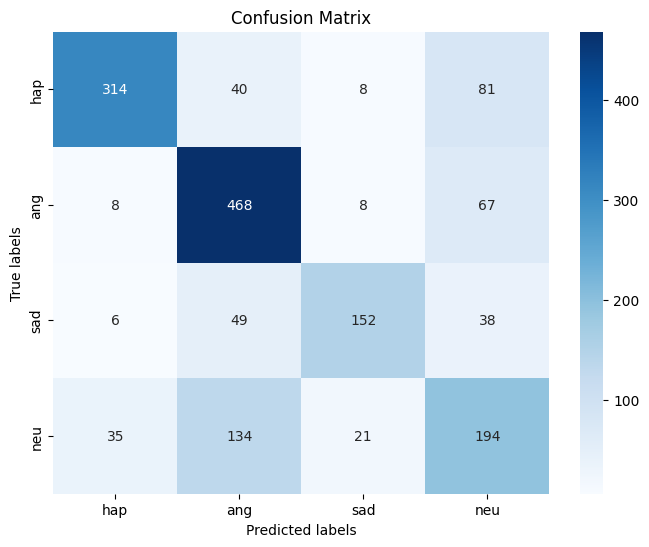

In [95]:
# Late Fusion model
late_fusion_model = LateFusionModel(num_classes=5)
late_fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
late_fusion_model.fit(train_dataset, epochs=10, validation_data=validation_dataset)
late_fusion_model.evaluate_model(test_dataset)
late_fusion_model.print_metrics()